# git2net analysis for the networkx repository

First we import the required packages

In [260]:
import pygit2 as git2
import os
import shutil
import git2net
import pathpy as pp
import sqlite3
import pandas as pd
from datetime import date, datetime, timedelta
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.dates as mdates
import json 
import math
import copy
import networkx as nx
import random
from statistics import mean, stdev

import gambit
import numpy as np

#git_repo_url = 'https://github.com/microsoft/cntk'
#git_repo_url = 'https://github.com/bytecodealliance/wasmtime'
git_repo_url = 'https://github.com/pandas-dev/pandas.git'
#git_repo_url = 'https://github.com/curl/curl.git'
#git_repo_url = 'https://github.com/networkx/networkx.git'
#git_repo_url = 'https://github.com/numpy/numpy.git'
#git_repo_url = 'https://github.com/deepcharles/ruptures.git'
#git_repo_url = 'https://github.com/mwaskom/seaborn.git'
repo_owner = 'ansible'
repo_name = 'awx'
local_directory = '.'
git_repo_dir = 'repos/{r}4analysis'.format(r=repo_name)
sqlite_db_file = 'databases/{o}/{r}/{r}.db'.format(o=repo_owner, r=repo_name)
#sqlite_db_file = 'databases/{r}/{r}_rename.db'.format(r=repo_name)

# Commit stats

Min date:  2009-07-31 15:07:16
Max date:  2021-03-06 20:40:22


<BarContainer object of 4237 artists>

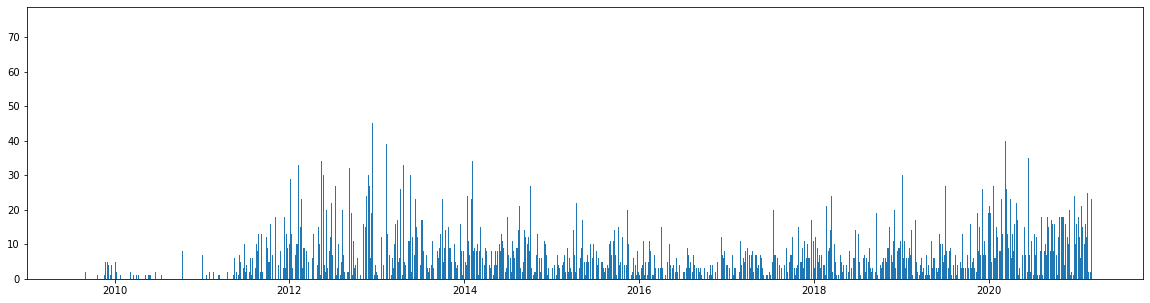

In [119]:
db = sqlite3.connect(sqlite_db_file)
max_date = datetime.strptime(pd.read_sql_query("SELECT max(committer_date) as max FROM commits", db)['max'].item(), '%Y-%m-%d %H:%M:%S')
min_date = datetime.strptime(pd.read_sql_query("SELECT min(committer_date) as min FROM commits", db)['min'].item(), '%Y-%m-%d %H:%M:%S')

print('Min date: ', min_date)
print('Max date: ', max_date)

pdCommits = pd.read_sql_query("SELECT * FROM commits", db)

days = {(min_date+timedelta(days=x)).date() : 0 for x in range((max_date-min_date).days + 1)}

commit_dates = pdCommits['committer_date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S').date()).value_counts()

for key in commit_dates.keys():
    days[key] = commit_dates.get(key)

keys = days.keys()
values = days.values()
plt.figure(figsize=(20,5))
plt.bar(keys, values)

## Bipartite networks
### Converting bipartite network into WOMP (weighted one-mode projection)

In [2]:
def collab_network(sqlite_db_file, git_repo_dir, t, node_info, min_date, max_date, file_base=True):
    if file_base:
        start = int(datetime.timestamp(min_date))
        end = int(datetime.timestamp(max_date))

        n = pp.Network.from_temporal_network(t, min_time=start, max_time=end)
        
        n = remove_duplicate_filenames(n, git_repo_dir)
        n = add_weights(n, node_info)
        
        new_n = copy.deepcopy(n)

        for node1 in n.nodes:
            if node_info['class'][node1] == 'author':
                for node2 in n.nodes:
                    if node_info['class'][node2] == 'author' and node1 != node2:
                        intersect = n.successors[node1].intersection(n.successors[node2])
                        w = 0
                        for file in intersect:
                            #print((node1, file), ':', n.edges[(node1, file)])
                            w = w + n.edges[(node1, file)]['wijLR']
                        if w > 0:
                            new_n.add_edge(node1, node2, weight=w)

        for node in n.nodes:
            if node_info['class'][node] == 'file':
                new_n.remove_node(node)

        return new_n
    else:
        n, node_info, edge_info = git2net.get_coauthorship_network(sqlite_db_file, time_from=min_date, time_to=max_date)
        return n

In [3]:
def remove_duplicate_filenames(n, git_repo_dir):
    all_files = []
    for path, subdirs, files in os.walk(git_repo_dir):
        for name in files:
            all_files.append(name)

    duplicates = [file for file in all_files if all_files.count(file) > 1]
    remove_files = set(duplicates)

    new_n = copy.deepcopy(n)
    for node in new_n.nodes:
        if node in remove_files:
            n.remove_node(node)
    del new_n
    return n

In [4]:
def duplicate_filenames(git_repo_dir):
    all_files = []
    for path, subdirs, files in os.walk(git_repo_dir):
        for name in files:
            all_files.append(name)

    duplicates = [file for file in all_files if all_files.count(file) > 1]
    remove_files = set(duplicates)
    print(len(remove_files))
    
    #keep_nodes = [f for f in all_files if f not in remove_files]
    #print(len(keep_nodes))
    #print(keep_nodes)
    
    #t = t.filter_nodes(keep_nodes)

    #new_n = copy.deepcopy(n)
    #for node in new_n.nodes:
    #    if node in remove_files:
    #        n.remove_node(node)
    #del new_n
    return remove_files

In [5]:
def add_weights(n, node_info):
    for node in n.nodes:
        if node_info['class'][node] == 'author':
            s = 0
            for successor in n.successors[node]:
                for key in n.edges:
                    if key[0] == node and key[1] == successor:
                        s = s + n.edges[key]['weight']

        n.nodes[node]['WiL'] = s
    for edge in n.edges:
        n.edges[edge]['wijLR'] = n.edges[edge]['weight'] / n.nodes[edge[0]]['WiL']
    
    return n

In [6]:
def collab_network_jaccard(sqlite_db_file, git_repo_dir, t, node_info, min_date, max_date, duplicate_files, file_base=True, is_temp=True):
    if file_base:
        start = int(datetime.timestamp(min_date))
        end = int(datetime.timestamp(max_date))
        
        #print('1. From temporal network...')
        if is_temp:
            n = pp.Network.from_temporal_network(t, min_time=start, max_time=end)
        else:
            n = t
        
        #print('2. Remove duplicate files... SKIPPED')
        #n = remove_duplicate_filenames(n, git_repo_dir)
        
        #print('3. New empty network')
        new_n = pp.Network(directed=False)
        
        #print('4. Add authors to network')
        nn = copy.deepcopy(n.nodes)
        for node in nn:
            if node_info['class'][node] != 'file':
                new_n.add_node(node)
            elif node in duplicate_files:
                n.remove_node(node)
        
        #new_n = new_n.to_undirected()  
        
        #print('5. Jaccard loop')
        visited_nodes = []
        for node1 in n.nodes:
            if node_info['class'][node1] == 'author':
                for node2 in n.nodes:
                    if node_info['class'][node2] == 'author' and node1 != node2 and not node2 in visited_nodes:
                        intersect = n.successors[node1].intersection(n.successors[node2])
                        w_min = 0
                        w_max = 0
                        for file in intersect:
                            #print((node1, file), ':', n.edges[(node1, file)])
                            w_min = w_min + min(n.edges[(node1, file)]['weight'], n.edges[(node2, file)]['weight'])
                            w_max = w_max + max(n.edges[(node1, file)]['weight'], n.edges[(node2, file)]['weight'])
                        if w_max > 0:
                            new_n.add_edge(node1, node2, weight=w_min/w_max)
                visited_nodes.append(node1)
                
                
        return new_n
    else:
        n, node_info, edge_info = git2net.get_coauthorship_network(sqlite_db_file, time_from=min_date, time_to=max_date)
        return n

In [7]:
def pathpy_to_networkx(n):
    G = nx.Graph()
    for node in n.nodes:
        G.add_node(node)
    
    for n1, n2 in n.edges:
        G.add_edge(n1, n2, weight=n.edges[(n1, n2)]['weight'])
        
    return G

In [8]:
def network_stats_nx(G):
    d = {}

    degrees = dict(G.degree())

    clust_coeff = nx.clustering(G, weight='weight')

    deg_centrality = nx.degree_centrality(G)
    max_dc = max(deg_centrality.values())
    sum_dc = 0    
    for node in deg_centrality:
        sum_dc = sum_dc + (max_dc - deg_centrality[node])

    shortest_paths = nx.shortest_path_length(G, weight='weight')
    s_p = 0
    i = 0
    for start, targets in shortest_paths:
        s_p = s_p + sum(targets.values())
        i = i + len(targets.values())
    
    k_core = len([x for x in nx.core_number(G) if nx.core_number(G)[x] >= max(nx.core_number(G).values())*0.8])
    deg_c_core = len([x for x in deg_centrality if deg_centrality[x] >= max(deg_centrality.values())*0.8])
    
    x=[]
    y=[]
    for node in G.nodes:
        if not (G.degree[node] == 0 and clust_coeff[node] == 0):
            x.append(G.degree[node])
            y.append(clust_coeff[node])
    
    d['Number of nodes'] = G.number_of_nodes()
    d['Network density'] = nx.density(G)
    d['Mean degree'] = sum(degrees.values())/len(degrees.values())
    d['Degree centrality'] = sum_dc / (G.number_of_nodes() - 2)
    d['Clustering coeff.'] = sum(clust_coeff.values())/len(clust_coeff.values())
    d['Mean path length'] = s_p / i
    d['Connected components'] = nx.number_connected_components(G)
    d['K-Core count'] = k_core
    d['Core/periphery (k-core)'] = k_core / G.number_of_nodes()
    d['Degree centrality core'] = deg_c_core
    d['Core/periphery (degree)'] = deg_c_core / G.number_of_nodes()
    try:
        d['Hierarchy'] = np.polyfit(x, y, 1)[0]
    except TypeError:
        d['Hierarchy'] = 0
    
    return d

In [9]:
def generate_random_network(n, node_info):
    rnet = pp.Network(directed=True)
    files = [x for x in node_info['class'] if node_info['class'][x] == 'file' and x in n.nodes]
    #print(len(files))
    authors = [x for x in node_info['class'] if node_info['class'][x] == 'author' and x in n.nodes]
    #print(len(authors))
    
    for edge in n.edges:
        rnet.add_edge(random.choice(authors), random.choice(files))
    
    return rnet

In [107]:
t, node_info, edge_info = git2net.get_bipartite_network(sqlite_db_file)
nj1 = collab_network_jaccard(sqlite_db_file, git_repo_dir, t, node_info, datetime(2014, 1, 1), datetime(2015, 12, 31), True)
nj2 = collab_network_jaccard(sqlite_db_file, git_repo_dir, t, node_info, datetime(2014, 1, 1), datetime(2014, 12, 31), True)
nj3 = collab_network_jaccard(sqlite_db_file, git_repo_dir, t, node_info, datetime(2014, 1, 1), datetime(2014, 6, 30), True)
nj4 = collab_network_jaccard(sqlite_db_file, git_repo_dir, t, node_info, datetime(2014, 1, 1), datetime(2014, 3, 31), True)
nj5 = collab_network_jaccard(sqlite_db_file, git_repo_dir, t, node_info, datetime(2014, 1, 1), datetime(2014, 1, 31), True)
nj6 = collab_network_jaccard(sqlite_db_file, git_repo_dir, t, node_info, datetime(2014, 1, 1), datetime(2014, 1, 8), True)
n1 = collab_network(sqlite_db_file, git_repo_dir, t, node_info, datetime(2014, 1, 1), datetime(2015, 12, 31), True)
n2 = collab_network(sqlite_db_file, git_repo_dir, t, node_info, datetime(2014, 1, 1), datetime(2014, 12, 31), True)
n3 = collab_network(sqlite_db_file, git_repo_dir, t, node_info, datetime(2014, 1, 1), datetime(2014, 6, 30), True)
n4 = collab_network(sqlite_db_file, git_repo_dir, t, node_info, datetime(2014, 1, 1), datetime(2014, 3, 31), True)
n5 = collab_network(sqlite_db_file, git_repo_dir, t, node_info, datetime(2014, 1, 1), datetime(2014, 1, 31), True)
n6 = collab_network(sqlite_db_file, git_repo_dir, t, node_info, datetime(2014, 1, 1), datetime(2014, 1, 8), True)

In [258]:
t, node_info, edge_info = git2net.get_bipartite_network(sqlite_db_file, time_from=datetime(2019, 1, 1), time_to=datetime(2021, 3, 31))

### Network statistics over time plots

In [ ]:
#stats = network_stats(n1)
#stats

db = sqlite3.connect(sqlite_db_file)
max_date = datetime.strptime(pd.read_sql_query("SELECT max(committer_date) as max FROM commits", db)['max'].item(), '%Y-%m-%d %H:%M:%S')
#min_date = datetime.strptime(pd.read_sql_query("SELECT min(committer_date) as min FROM commits", db)['min'].item(), '%Y-%m-%d %H:%M:%S')
#max_date = datetime.strptime('2020-12-31 00:00:00', '%Y-%m-%d %H:%M:%S')
min_date = datetime.strptime('2018-01-01 00:00:00', '%Y-%m-%d %H:%M:%S')

print('Min date: ', min_date)
print('Max date: ', max_date)

#t, node_info, edge_info = git2net.get_bipartite_network(sqlite_db_file, time_from=min_date, time_to=max_date)
print('0. Remove duplicate files')
#duplicate_files = duplicate_filenames(git_repo_dir)

timespan = timedelta(days=30) # Timespan to be considered for the stats
days = {(min_date+timedelta(days=x)).date() : 0 for x in range((max_date-min_date-timespan).days + 1)}
stats = []
random_stats = []
x = []

stat_names = [
    'Number of nodes', 'Network density', 'Mean degree', 'Degree centrality', 'Clustering coeff.', 'Mean path length', 
    'Connected components', 'K-Core count', 'Core/periphery (k-core)', 'Degree centrality core', 'Core/periphery (degree)',
    'Hierarchy'
]

for day in days:
    print(day.strftime('%Y-%m-%d'))
    x.append(day)
    start = datetime.combine(day, datetime.min.time())
    end = datetime.combine(day+timespan, datetime.min.time())
    #n = collab_network(sqlite_db_file, git_repo_dir, t, node_info, day, day+timespan, True)
    n_bip = pp.Network.from_temporal_network(t, min_time=int(datetime.timestamp(start)), max_time=int(datetime.timestamp(end)))
    rstat = []
    for i in range(10):
        rnet_bip = generate_random_network(n_bip, node_info)
        rnet = collab_network_jaccard(sqlite_db_file, git_repo_dir, rnet_bip, node_info, start, end, duplicate_files, True, False)
        Gr = pathpy_to_networkx(rnet)
        s = network_stats_nx(Gr)
        rstat.append(s)
    
    n = collab_network_jaccard(sqlite_db_file, git_repo_dir, t, node_info, start, end, duplicate_files, True)
    G = pathpy_to_networkx(n)
    s=network_stats_nx(G)
    stats.append(s)
    
    zstat = {}
    for sname in stat_names:
        l = [x[sname] for x in rstat]
        try:
            zstat[sname] = (s[sname] - mean(l)) / stdev(l)
        except ZeroDivisionError:
            zstat[sname] = None
            #zstat[sname] = (s[sname] - mean(l))
    random_stats.append(zstat)

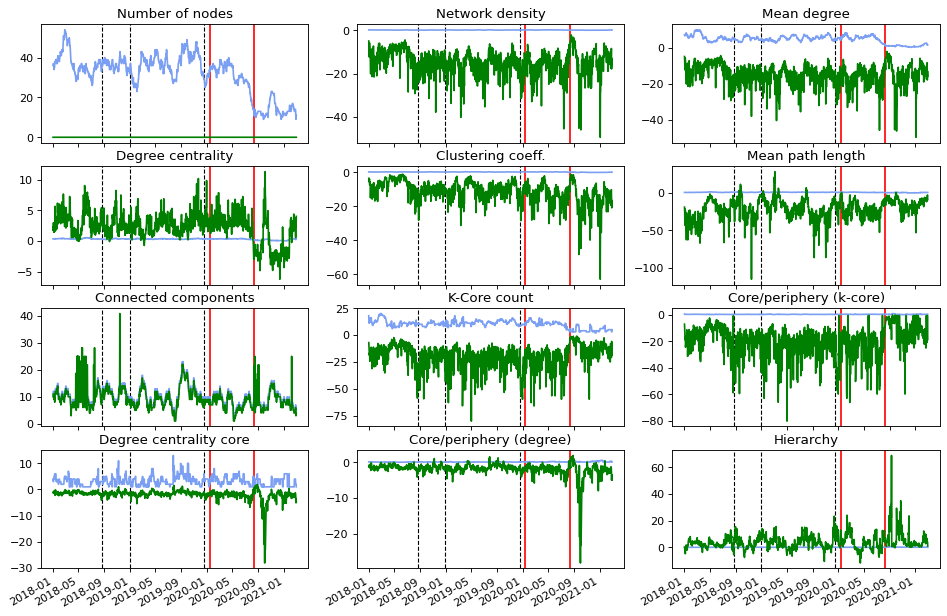

In [394]:
fig = plt.figure(figsize=(14.5, 10), dpi=80)
gs = fig.add_gridspec(4, 3, hspace=0.2, wspace=0.18)
plots = gs.subplots(sharex=True)
myFmt = mdates.DateFormatter('%Y-%m')

i = 0

for plot_row in plots:
    for plot in plot_row:
        try:
            plot.set_title(stat_names[i])
            for r in servo_releases:
                if servo_releases[r] == 'major':
                    plot.axvline(x=r, color='black', ls='-')
                elif servo_releases[r] == 'minor':
                    plot.axvline(x=r, color='black', ls='--', lw=1)
                elif servo_releases[r] == 'subminor':
                    plot.axvline(x=r, color='black', ls=':', lw=0.5)
                else:
                    plot.axvline(x=r, color='red', ls='-')
            plot.plot(x, [y[stat_names[i]] for y in stats], label = stat_names[i], color = "#7B9FF2")
            plot.plot(x, [y[stat_names[i]] for y in random_stats], label = stat_names[i] + ' - random', color = "green")
            plot.xaxis.set_major_formatter(myFmt)
            i = i + 1
        except IndexError:
            pass
        
        
fig.autofmt_xdate()

# Releases metrics

In [287]:
db = sqlite3.connect(sqlite_db_file)
with open('edits_query.sql', 'r') as f:
    sql = f.read()
    
edits = pd.read_sql_query(sql, db)
#edits

db = sqlite3.connect('../../repo_tools/repo_tools/joci_releases.db')
with open('releases_query.sql', 'r') as f:
    sql = f.read().format(owner='\'' + repo_owner + '\'', repo_name='\'' + repo_name + '\'')
    #sql = f.read().format(owner='\'ansible\'', repo_name='\'awx\'')
 
releases = pd.read_sql_query(sql, db)

with open('issues_query.sql', 'r') as f:
    sql = f.read().format(owner='\'' + repo_owner + '\'', repo_name='\'' + repo_name + '\'')
    #sql = f.read().format(owner='\'ansible\'', repo_name='\'awx\'')
 
issues = pd.read_sql_query(sql, db)

with open('feature_keywords.json','r') as f:
    feature_keywords = json.load(f)

with open('bug_keywords.json','r') as f:
    bug_keywords = json.load(f)

with open('drop_words.json','r') as f:
    drop_words = json.load(f)

issues['issue_title'] = issues['issue_title'].str.lower().str.replace('|'.join(drop_words),'', regex=True)

issues['is_feature'] = issues['issue_title'].str.contains('|'.join(feature_keywords))
issues['is_bug'] = issues['issue_title'].str.contains('|'.join(bug_keywords))

issues['bug_or_feature'] = 'unknown'
issues.loc[(issues['is_feature'] == True) & (issues['is_bug'] == False), 'bug_or_feature'] = 'feature'
issues.loc[(issues['is_feature'] == False) & (issues['is_bug'] == True), 'bug_or_feature'] = 'bug'
del issues['is_bug']
del issues['is_feature']

issues['created_at'] = pd.to_datetime(issues['created_at'], format='%Y-%m-%dT%H:%M:%SZ')
issues['closed_at'] = pd.to_datetime(issues['closed_at'], format='%Y-%m-%dT%H:%M:%SZ')

edits[pd.isnull(edits['lines_added']) | pd.isnull(edits['lines_removed'])] = 0 # Binary file changes have lines of NaN --> consider as 0 lines changed
edits = edits.drop(edits[edits['hash'] == 0].index) # Sometimes the hash is 0, with all the other columns, and this leads to TypeError
edits['author_date'] = pd.to_datetime(edits['author_date'], format='%Y-%m-%d %H:%M:%S')
releases.sort_values(by=['created_at'])
releases['created_at'] = pd.to_datetime(releases['created_at'], format='%Y-%m-%dT%H:%M:%SZ')
releases['prev_created_at'] = releases.created_at.shift()
releases['prev_tag_name'] = releases.tag_name.shift()

In [262]:
releases

,name,tag_name,created_at,prev_created_at,prev_tag_name
0,,16.0.0,2020-12-10 17:40:14,NaT,NaN
1,,17.0.0,2021-01-22 06:14:24,2020-12-10 17:40:14,16.0.0
2,17.0.1,17.0.1,2021-01-26 18:30:41,2021-01-22 06:14:24,17.0.0
3,17.1.0,17.1.0,2021-03-10 13:53:25,2021-01-26 18:30:41,17.0.1
4,18.0.0,18.0.0,2021-03-23 14:49:19,2021-03-10 13:53:25,17.1.0
5,19.0.0,19.0.0,2021-04-07 19:59:11,2021-03-23 14:49:19,18.0.0


In [288]:
versions = releases['tag_name'].str.extract(r'.*(\d+)\.(\d+)\.(\d+).*')
#pd.isnull(versions)
versions_prev = releases['prev_tag_name'].str.extract(r'.*(\d+)\.(\d+)\.(\d+).*')
versions_prev[0] == versions[0]
releases['release_type'] = 'unknown'
releases.loc[(versions[0] != versions_prev[0]) & (pd.isnull(versions_prev[0]) == False), 'release_type'] = 'major'
releases.loc[
    ((versions[0] == versions_prev[0]) | 
    (pd.isnull(versions_prev[0]) == True)) &
    ((versions[1] != versions_prev[1]) &
    (pd.isnull(versions_prev[1]) == False)),
    'release_type'
] = 'minor'
releases.loc[
    ((versions[0] == versions_prev[0]) | 
    (pd.isnull(versions_prev[0]) == True)) & 
    ((versions[1] == versions_prev[1]) | 
    (pd.isnull(versions_prev[1]) == True)) & 
    ((versions[2] != versions_prev[2]) & 
    (pd.isnull(versions_prev[2]) == False)), 
    'release_type'
] = 'patch'

r = {
    "no_of_modifications": [],
    "lines_added": [],
    "lines_removed": []
}
for index, row in releases.iterrows():
    for col in r:
        if pd.isnull(row['prev_created_at']):
            #print(edits['author_date'], type(edits['author_date']))
            #print(row['created_at'], type(row['created_at']))
            r[col].append(sum(edits.loc[(edits['author_date'] < row['created_at']), col]))
            continue
        r[col].append(sum(edits.loc[(edits['author_date'] >= row['prev_created_at']) & (edits['author_date'] < row['created_at']), col]))
    
releases['no_of_modifications'] = r['no_of_modifications']
releases['lines_added'] = r['lines_added']
releases['lines_removed'] = r['lines_removed']
releases['lines_changed'] = releases['lines_added'] + releases['lines_removed']
releases

,name,tag_name,created_at,prev_created_at,prev_tag_name,release_type,no_of_modifications,lines_added,lines_removed,lines_changed
0,,16.0.0,2020-12-10 17:40:14,NaT,NaN,unknown,67669,5.922565e+09,4.453986e+09,1.037655e+10
1,,17.0.0,2021-01-22 06:14:24,2020-12-10 17:40:14,16.0.0,major,657,1.432957e+08,1.293298e+08,2.726255e+08
2,17.0.1,17.0.1,2021-01-26 18:30:41,2021-01-22 06:14:24,17.0.0,patch,94,3.853007e+08,4.906062e+06,3.902068e+08
3,17.1.0,17.1.0,2021-03-10 13:53:25,2021-01-26 18:30:41,17.0.1,minor,1172,3.119956e+06,1.217160e+07,1.529155e+07
4,18.0.0,18.0.0,2021-03-23 14:49:19,2021-03-10 13:53:25,17.1.0,major,229,2.712920e+05,8.765100e+04,3.589430e+05
5,19.0.0,19.0.0,2021-04-07 19:59:11,2021-03-23 14:49:19,18.0.0,major,273,3.063900e+05,1.912580e+05,4.976480e+05


<BarContainer object of 1341 artists>

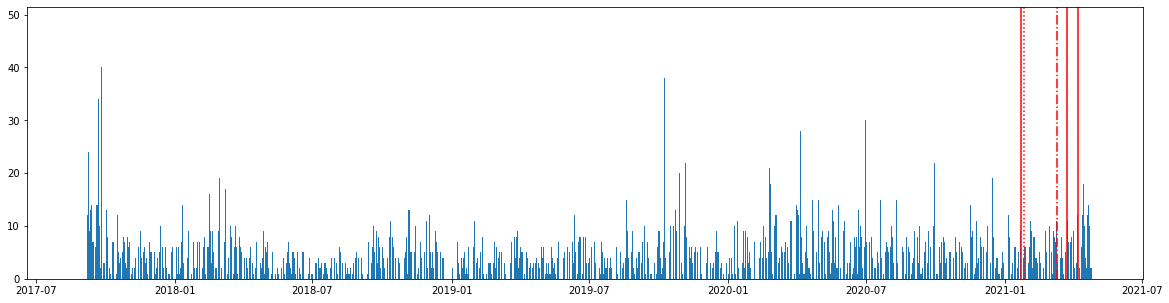

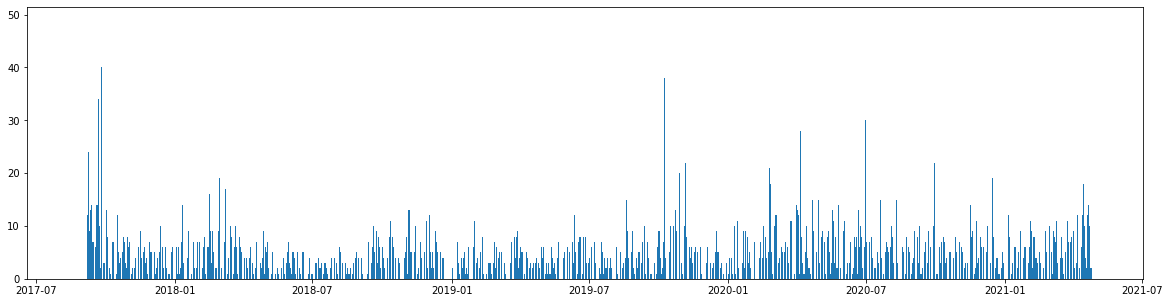

In [292]:
min_d = np.datetime64(min(issues['created_at'])).astype(datetime)
max_d = np.datetime64(max(issues['created_at'])).astype(datetime)

days = {(min_d+timedelta(days=x)).date() : 0 for x in range((max_d-min_d).days + 2)}

for issue in issues['created_at']:
    day = np.datetime64(issue).astype(datetime).date()
    days[day] = days[day] + 1

    

keys = days.keys()
values = days.values()
plt.figure(figsize=(20,5))
for index, row in releases.iterrows():
    if row['release_type'] == 'major':
        plt.axvline(x=row['created_at'], color='red', ls='-')
    elif row['release_type'] == 'minor':
        plt.axvline(x=row['created_at'], color='red', ls='-.')
    elif row['release_type'] == 'patch':
        plt.axvline(x=row['created_at'], color='red', ls=':')
plt.bar(keys, values)
plt.figure(figsize=(20,5))
plt.bar(keys, values)

In [277]:
max_d

datetime.datetime(2021, 4, 26, 5, 20, 54)